# Save MRS spectrophotometric response to CDP

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')

In [1]:
# import modules
import funcs
import mrsobs

import numpy as np
from astropy.io import fits
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
plt.style.use('presentation')
%matplotlib notebook

import warnings
warnings.simplefilter('ignore')

In [2]:
bands = ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C"]

In [3]:
# Define paths to data
workDir       = '/Users/ioannisa/Desktop/python/miri_devel/'
cdpDir        = workDir+'cdp_data/'
d2cMapDir     = workDir+'notebooks/distortionMaps/'
dichroicDir   = workDir+'MRSWaveCal/MrsFilterTransmissions/'
MTSDir        = workDir+'notebooks/pyMTSSim/OUTPUT/'
lvl2path      = workDir+'FM_data/LVL2/'

# Populate dictionaries with the wavelength, pixel size and validity maps 
# (corresponding to the detector plane)

sliceMap  = {}
sizeMap   = {}
validMap  = {}
lambdaMap = {}

for band in bands:
    print "Band {}".format(band)
    d2cMaps         = funcs.load_obj('d2cMaps_band{}_tr10pc'.format(band),path=d2cMapDir)
    sliceMap[band]  = d2cMaps['sliceMap']
    lambdaMap[band] = d2cMaps['lambdaMap']
    sizeMap[band]   = funcs.get_pixel_spatial_area(band,d2cMaps)
    
    # create a "valid" map with all the pixels inside the slices of a particular band
    channel = int(band[0])
    # slice numbers in the slice map of the distortion CDP for this band
    sliceInventory = np.unique(sliceMap[band])
    slicesInBand = sliceInventory[np.where( (sliceInventory >= 100*channel ) & (sliceInventory <100*(channel+1)))]
    
    validMap[band] = np.zeros(sliceMap[band].shape)
    for ss in slicesInBand:
        s = int(ss - 100*channel)
        # construct a list of y,x coordinates of detector pixels belonging to slices of this band
        pixels = np.where(sliceMap[band] == ss)
        validMap[band][pixels] = 1

Band 1A
Band 1B
Band 1C
Band 2A
Band 2B
Band 2C
Band 3A
Band 3B
Band 3C
Band 4A
Band 4B
Band 4C


<IPython.core.display.Javascript object>


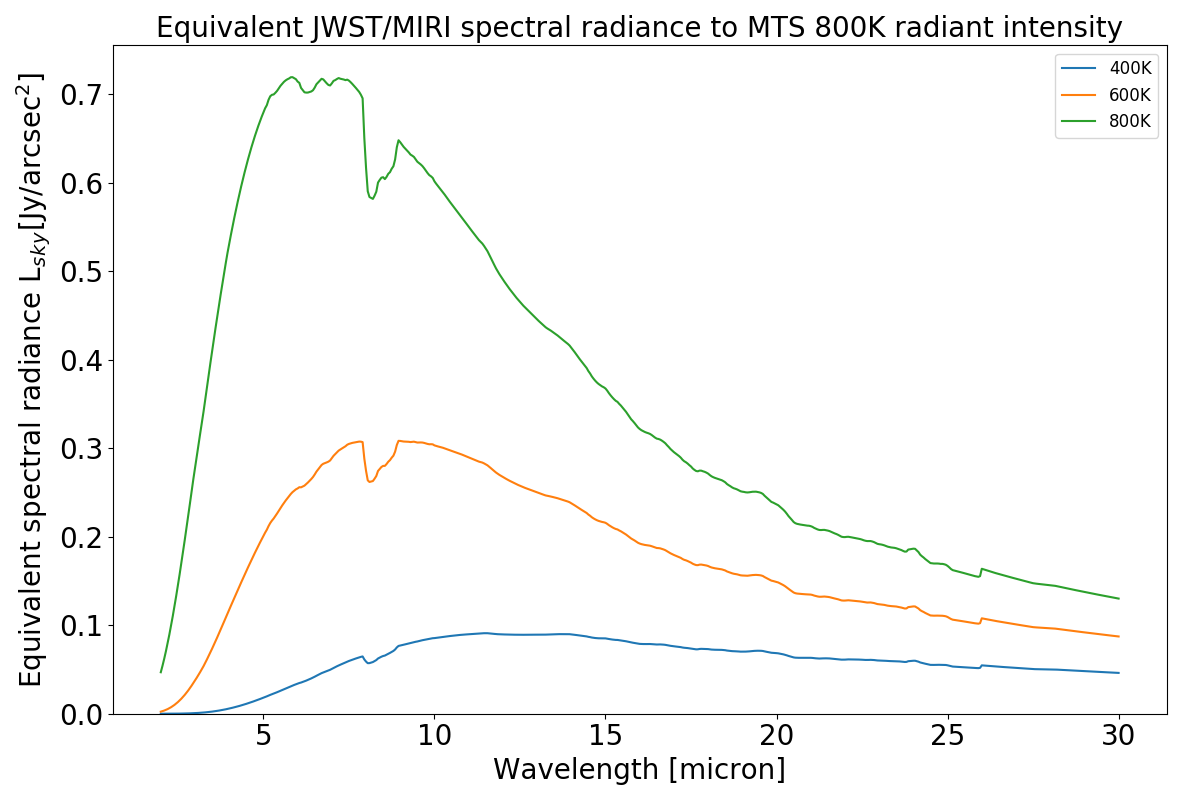

<IPython.core.display.Javascript object>


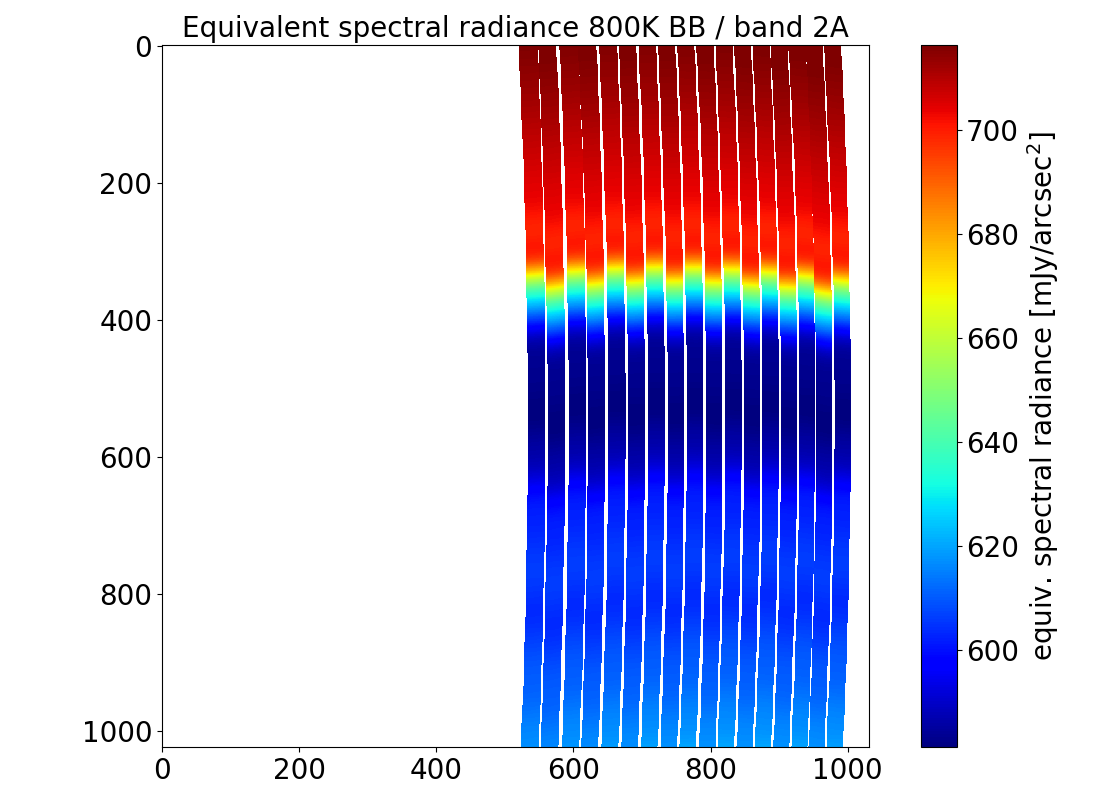

In [4]:
# Populate dictionaries with maps of L_sky
L_skyMap = {}
plt.figure(figsize=(12,8))
plt.title('Equivalent JWST/MIRI spectral radiance to MTS 800K radiant intensity',fontsize=20)
for BBTemp in ["400K","600K","800K"]:
    L_skyMap[BBTemp] = {}   
    tabLSky = fits.open(MTSDir+ "MTSEquivalentLsky" + BBTemp + ".fits" )[1]
    ip_Lsky = interp1d(tabLSky.data["wave"], tabLSky.data["L_sky"], kind='cubic')
    plt.plot(tabLSky.data["wave"],tabLSky.data["L_sky"],label='{}'.format(BBTemp))
    for band in ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C"]:
        L_skyMap[BBTemp][band] = np.full( validMap[band].shape, np.nan )
        sel = (validMap[band]==1)
        waves = np.reshape(lambdaMap[band][sel], -1)
        L_skyMap[BBTemp][band][sel] = ip_Lsky(waves)*1000. #mJy/arcsec^2
plt.ylim(0)
plt.xlabel('Wavelength [micron]')
plt.ylabel('Equivalent spectral radiance L$_s$$_k$$_y$[Jy/arcsec$^2$]')
plt.legend(loc='upper right',fontsize=12)
plt.tight_layout()

plt.figure(figsize=(11,8))
plt.imshow(L_skyMap["800K"]["2A"],cmap='jet')
clb = plt.colorbar()
clb.set_label('equiv. spectral radiance [mJy/arcsec$^2$]')
plt.title("Equivalent spectral radiance 800K BB / band 2A")
plt.tight_layout()

BBTemp 400K
BBTemp 600K
BBTemp 800K


<IPython.core.display.Javascript object>


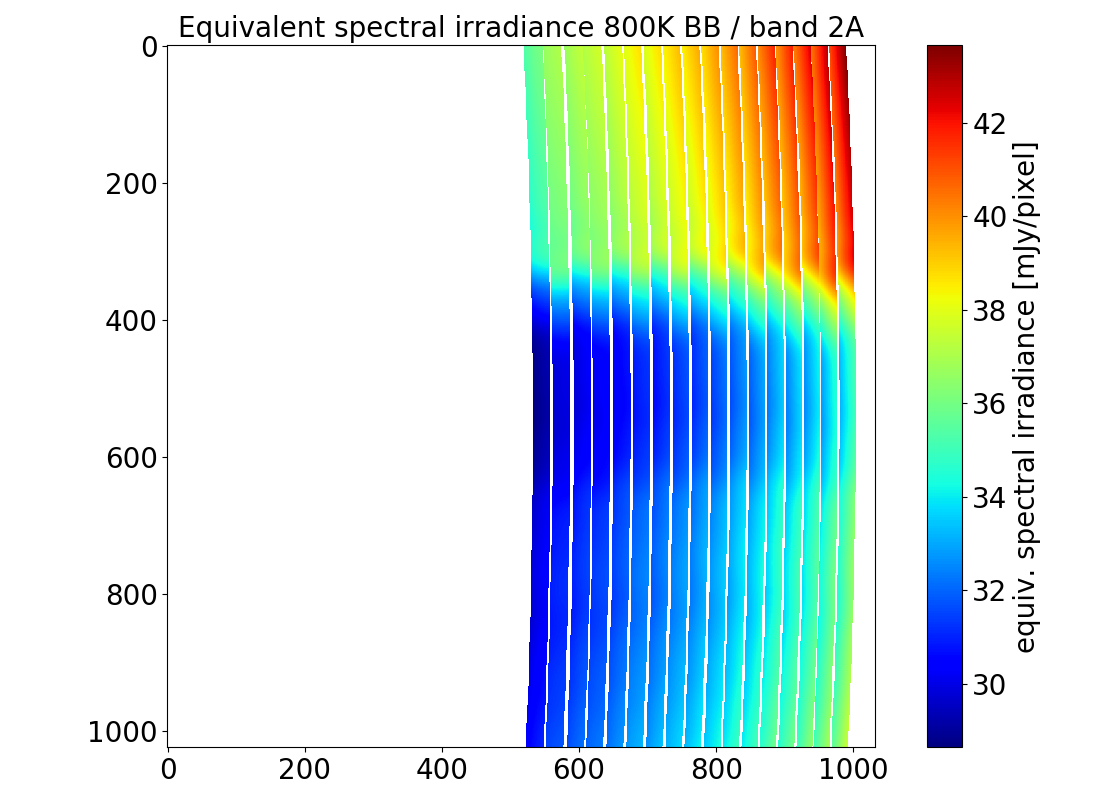

In [5]:
# Populate dictionaries with maps of E_pix
# Calculate the spectral irradiance E_pix : [mJy/pixel]
# E_pix = omega_pix * L_pix
E_pixMap = {}
for BBTemp in ["400K", "600K", "800K"]:
    print "BBTemp {}".format(BBTemp)
    E_pixMap[BBTemp] = {}
    for band in ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C"]:
        E_pixMap[BBTemp][band] = np.full( validMap[band].shape, np.nan )
        sel = (validMap[band]==1)
        E_pixMap[BBTemp][band][sel] = sizeMap[band][sel] * L_skyMap[BBTemp][band][sel]
        
plt.figure(figsize=(11,8))
plt.imshow(E_pixMap["800K"]["2A"],cmap='jet')
clb = plt.colorbar()
clb.set_label('equiv. spectral irradiance [mJy/pixel]')
plt.title("Equivalent spectral irradiance 800K BB / band 2A")
plt.tight_layout()

In [6]:
# Populate dictionaries with maps of S_pix [DN/sec] and dS_pix (the error)
# S_pix is the average slope of the BB measurement with the average slope of the
# background measurement subtracted.
# We also populate the Bad pixel map (0 = ok, 1 = do not use)

#-- Uncomment to re-run
S_pixMap = {}
dS_pixMap = {}
BadPixelMap ={}
for BBTemp in ["400K","600K", "800K"]:
    print "BBTemp {}".format(BBTemp)
    S_pixMap[BBTemp] = {}
    dS_pixMap[BBTemp] = {}
    BadPixelMap[BBTemp] = {}
    for band in ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C"]:
        print "Band {}".format(band)
        S_pixMap[BBTemp][band] = np.full( validMap[band].shape, np.nan )
        dS_pixMap[BBTemp][band] = np.full( validMap[band].shape, np.nan )
        BadPixelMap[BBTemp][band] = np.full( validMap[band].shape, 0 )
        hdulist = fits.open(mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp=BBTemp,output='filename')[0])
        slopeHOLE = hdulist[0].data[0,:,:]
        dslopeHOLE = hdulist[0].data[1,:,:]
        maskHOLE = hdulist[0].data[2,:,:]
        hdulist = fits.open(mrsobs.FM_MTS_BB_extended_source(lvl2path,band,bb_temp=BBTemp,output='filename')[1])
        slopeBLANK = hdulist[0].data[0,:,:]
        dslopeBLANK = hdulist[0].data[1,:,:]
        maskBLANK = hdulist[0].data[2,:,:]
        sel = (validMap[band]==1) & (maskHOLE==0) & (maskBLANK==0)
        S_pixMap[BBTemp][band][sel] = slopeHOLE[sel] - slopeBLANK[sel]
        dS_pixMap[BBTemp][band][sel] = np.sqrt(dslopeHOLE[sel]**2 + dslopeBLANK[sel]**2)
        BadPixelMap[BBTemp][band][(validMap[band]==1) & (maskHOLE>0) & (maskBLANK>0)] = 1

BBTemp 400K
Band 1A
Band 1B
Band 1C
Band 2A
Band 2B
Band 2C
Band 3A
Band 3B
Band 3C
Band 4A
Band 4B
Band 4C
BBTemp 600K
Band 1A
Band 1B
Band 1C
Band 2A
Band 2B
Band 2C
Band 3A
Band 3B
Band 3C
Band 4A
Band 4B
Band 4C
BBTemp 800K
Band 1A
Band 1B
Band 1C
Band 2A
Band 2B
Band 2C
Band 3A
Band 3B
Band 3C
Band 4A
Band 4B
Band 4C


In [7]:
# Load the latest fringe calibration maps
ff= {}
ff["LONGLONG"]=fits.open(cdpDir+"CDP7/MIRI_FM_MIRIFULONG_34LONG_FRINGE_7B.02.01.fits")[1].data
ff["LONGMEDIUM"]=fits.open(cdpDir+"CDP7/MIRI_FM_MIRIFULONG_34MEDIUM_FRINGE_7B.02.01.fits")[1].data
ff["LONGSHORT"]=fits.open(cdpDir+"CDP7/MIRI_FM_MIRIFULONG_34SHORT_FRINGE_7B.02.01.fits")[1].data
ff["SHORTLONG"]=fits.open(cdpDir+"CDP7/MIRI_FM_MIRIFUSHORT_12LONG_FRINGE_7B.02.06.fits")[1].data
ff["SHORTMEDIUM"]=fits.open(cdpDir+"CDP7/MIRI_FM_MIRIFUSHORT_12MEDIUM_FRINGE_7B.02.06.fits")[1].data
ff["SHORTSHORT"]=fits.open(cdpDir+"CDP7/MIRI_FM_MIRIFUSHORT_12SHORT_FRINGE_7B.02.06.fits")[1].data

In [8]:
# Populate dictionaries with maps of R_pix [DN/sec/mJy/pixel] and dR_pix 
# 
        
R_pixMap_oldFringe,R_pixMap  = {},{}
dR_pixMap = {}

for BBTemp in ["400K","600K", "800K"]:
    print "BBTemp {}".format(BBTemp)
    R_pixMap_oldFringe[BBTemp],R_pixMap[BBTemp] = {},{}
    dR_pixMap[BBTemp] = {}
    for band in ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C"]:
        # pre-CDP7 fringe calibration
        fringe_img_old = funcs.get_cdps(band,cdpDir)[0]
        # post-CDP7 fringe calibration
        if band[0] in ['1','2']: chan = 'SHORT'
        elif band[0] in ['3','4']: chan = 'LONG'
        if band[1] == 'A': subchan = 'SHORT'
        elif band[1] == 'B': subchan = 'MEDIUM'
        elif band[1] == 'C': subchan = 'LONG'
        band_id = chan+subchan
        fringe_img_new = ff[band_id]
        R_pixMap_oldFringe[BBTemp][band] = np.full( validMap[band].shape, np.nan )
        R_pixMap[BBTemp][band] = np.full( validMap[band].shape, np.nan )
        dR_pixMap[BBTemp][band] = np.full( validMap[band].shape, np.nan )
        sel = (validMap[band]==1)& (BadPixelMap[BBTemp][band]==0)
        R_pixMap_oldFringe[BBTemp][band][sel] = (S_pixMap[BBTemp][band][sel] / E_pixMap[BBTemp][band][sel])/fringe_img_old[sel]
        R_pixMap[BBTemp][band][sel] = (S_pixMap[BBTemp][band][sel] / E_pixMap[BBTemp][band][sel])/fringe_img_new[sel]
        dR_pixMap[BBTemp][band][sel] = R_pixMap[BBTemp][band][sel] * dS_pixMap[BBTemp][band][sel]/S_pixMap[BBTemp][band][sel]

BBTemp 400K
BBTemp 600K
BBTemp 800K


In [9]:
# Populate dictionaries with maps of PHOTOM_pix [DN/sec/mJy/pixel] (from the MRS PHOTOM CDP)
# 
        
PHOTOM_pixMap = {}

for BBTemp in ["400K","600K", "800K"]:
    print "BBTemp {}".format(BBTemp)
    PHOTOM_pixMap[BBTemp] = {}
    for band in ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C"]:
        photom_img = funcs.get_cdps(band,cdpDir)[1]
        PHOTOM_pixMap[BBTemp][band] = np.full( validMap[band].shape, np.nan )
        sel = (validMap[band]==1)& (BadPixelMap[BBTemp][band]==0)
        PHOTOM_pixMap[BBTemp][band][sel] = photom_img[sel]

BBTemp 400K
BBTemp 600K
BBTemp 800K


<IPython.core.display.Javascript object>


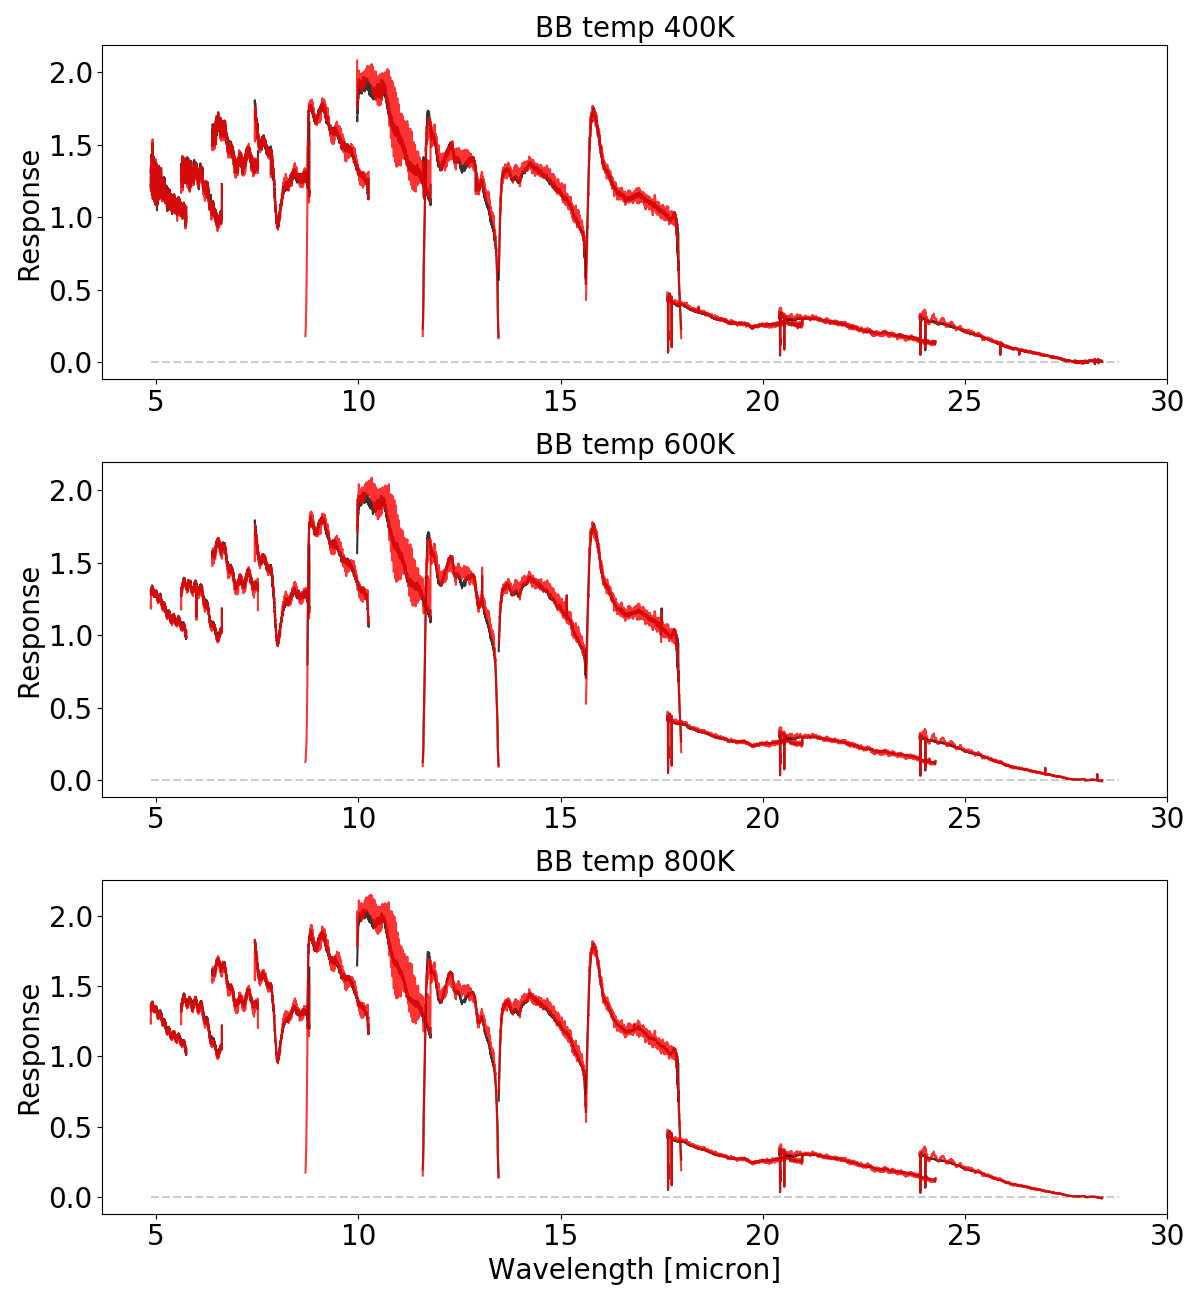

In [10]:
fig,axs = plt.subplots(3,1,figsize=(12,13))
plot = -1
for BBTemp in ["400K","600K", "800K"]:
    plot +=1
    for band in ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C"]:
        if band[0] in ['1','4']:
            xcol = 47
        elif band[0] in ['2','3']:
            xcol = 800
#         axs[plot].plot(lambdaMap[band][:,xcol],PHOTOM_pixMap[BBTemp][band][:,xcol],'b')
        axs[plot].plot(lambdaMap[band][:,xcol],R_pixMap_oldFringe[BBTemp][band][:,xcol],'k',alpha=0.8)
        axs[plot].plot(lambdaMap[band][:,xcol],R_pixMap[BBTemp][band][:,xcol],'r',alpha=0.8)
    axs[plot].hlines(0,4.88,28.8,'gray',alpha=0.4,linestyle='dashed')
#     legend_elements = [Line2D([0],[0],color='b',label='DHAS 9.1.4'),Line2D([0],[0],color='orange',alpha=0.8,label='DHAS 9.4.4')]
#     axs[plot].legend(handles=legend_elements)
    axs[plot].set_title("BB temp {}".format(BBTemp))
    axs[plot].set_ylabel('Response') # [DN sec^-1 mJy^-1 pixel]
axs[2].set_xlabel('Wavelength [micron]')
plt.tight_layout()

<IPython.core.display.Javascript object>


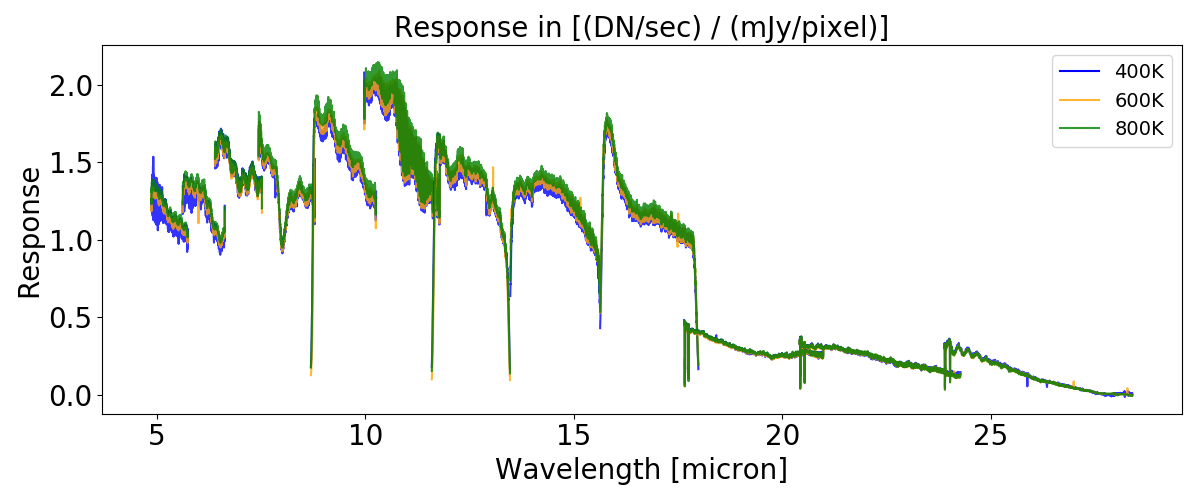

In [11]:
plt.figure(figsize=(12,5))
for band in ["1A", "1B", "1C", "2A", "2B", "2C", "3A", "3B", "3C", "4A", "4B", "4C"]:
    if band[0] in ['1','4']:
        xcol = 47
    elif band[0] in ['2','3']:
        xcol = 800
    plt.plot(lambdaMap[band][:,xcol],R_pixMap['400K'][band][:,xcol],'b',alpha=0.8)
    plt.plot(lambdaMap[band][:,xcol],R_pixMap['600K'][band][:,xcol],'orange',alpha=0.8)
    plt.plot(lambdaMap[band][:,xcol],R_pixMap['800K'][band][:,xcol],'g',alpha=0.8)
    
#     axs[plot].hlines(0,4.88,28.8,'gray',alpha=0.4,linestyle='dashed')
legend_elements = [Line2D([0],[0],color='b',label='400K'),Line2D([0],[0],color='orange',alpha=0.8,label='600K'),Line2D([0],[0],color='g',alpha=0.8,label='800K')]
plt.legend(handles=legend_elements,loc='upper right')
plt.title("Response in [(DN/sec) / (mJy/pixel)]")
plt.ylabel('Response') # [DN sec^-1 mJy^-1 pixel]
plt.xlabel('Wavelength [micron]')
plt.tight_layout()

# Save CDPs

In [12]:
# save responses to CDP
oldCdp = fits.open(cdpDir+"MIRI_FM_MIRIFUSHORT_SHORT_PHOTOM_06.03.02.fits")
dq_def = oldCdp[4]

In [13]:
outDir = cdpDir+"CDP7/"

In [14]:
def makeHeader(detector="MIRIFUSHORT", channel="12", band="SHORT"):
    hdu0 = fits.PrimaryHDU()
    hdu0.header["TELESCOP"]="JWST"
    hdu0.header["INSTRUME"]="MIRI"
    hdu0.header["MODELNAM"]=("FM", "Instrument model name")
    hdu0.header["DETECTOR"]=detector
    hdu0.header["DETSETNG"]="ANY"
    hdu0.header["READPATT"]="ANY"
    hdu0.header["SUBARRAY"]="GENERIC"
    hdu0.header["SUBSTRT1"]= 1                                            
    hdu0.header["SUBSIZE1"]= 1032                                              
    hdu0.header["SUBSTRT2"]= 1                                                
    hdu0.header["SUBSIZE2"]= 1024                                           
    hdu0.header["FASTAXIS"]= 1                                               
    hdu0.header["SLOWAXIS"]= 2
    hdu0.header["CHANNEL"] = channel
    hdu0.header["BAND"]    = band
    hdu0.header["FILENAME"]= "MIRI_FM_"+detector+"_"+channel+band+"_PHOTOM_7B.03.01.fits"
    hdu0.header["DATE"]="2018-11-13"
    hdu0.header["VERSION"] ="7B.03.01"
    hdu0.header["USEAFTER"] ="2000-01-01T00:00:00"
    hdu0.header["AUTHOR"]  ="Bart Vandenbussche"
    hdu0.header["ORIGIN"]  = "MIRI European Consortium"
    hdu0.header["EXP_TYPE"]= "MIR_MRS"
    hdu0.header["REFTYPE"] ="PHOTOM"
    hdu0.header["DESCRIP"] = 'CDP-7 MIRI MRS response'
    hdu0.header["PEDIGREE"] = 'GROUND'
    hdu0.header["PHOTMJSR"] = '42.5'
    hdu0.header["PHOTUJA2"] = '1000.0'
    hdu0.header.add_history("DOCUMENT: MIRI-TN-00003-KUL issue 1.2")
    hdu0.header.add_history("SOFTWARE: MIRICLE ")
    hdu0.header.add_history("DATA USED: RAL FM data obsId 11282 .. 11287")
    hdu0.header.add_history("DIFFERENCES: 06.03.00 Detector plane calibration (new format)")
    hdu0.header.add_history("DIFFERENCES: 06.03.01 Corrected error in PIXSIZ extension")
    hdu0.header.add_history("DIFFERENCES: 06.03.02 Fringe flat 06.02.00 applied")
    hdu0.header.add_history("DIFFERENCES: 7B.03.00 Renumbered to CDP7 Beta / fixed USEAFTER")
    hdu0.header.add_history("DIFFERENCES: 7B.03.01 Introduced 0.55 factor offset.")
    hdu0.header.add_history("DIFFERENCES: Used 10% transmission slice mask.")
    return hdu0

## SHORT SHORT = 1A / 2A

In [15]:
hdu0 = makeHeader(detector="MIRIFUSHORT", channel="12", band="SHORT")

resp = R_pixMap["800K"]["2A"].copy()
err = dR_pixMap["800K"]["2A"].copy()
size = sizeMap["2A"].copy()

sel = (validMap["1A"]==1)
resp[sel] = R_pixMap["800K"]["1A"][sel]
err[sel] = dR_pixMap["800K"]["1A"][sel]
size[sel] = sizeMap["1A"][sel]

sel = (( validMap["1A"] + validMap["2A"] )==1)
resp[sel] = resp[sel] # /ff["SHORTSHORT"][sel]

dq = np.full( validMap["1A"].shape, 2 )
sel = (validMap["1A"]==1)
dq[sel] = 0
sel = (validMap["2A"]==1)
dq[sel] = 0
dq = dq + BadPixelMap["800K"]["1A"]
dq = dq + BadPixelMap["800K"]["2A"]

hdu1 = fits.ImageHDU(data=resp, header=None, name="SCI")
hdu1.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu2 = fits.ImageHDU(data=err, header=None, name="ERR")
hdu2.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu3 = fits.ImageHDU(data=dq, header=None, name="DQ")
hdu4 = fits.ImageHDU(data=size, header=None, name="PIXSIZ")
hdu4.header["BUNIT"]= "arcsec^2"
hdulist = fits.HDUList([hdu0,hdu1, hdu2, hdu3, dq_def, hdu4])
hdulist.writeto(outDir + "MIRI_FM_MIRIFUSHORT_12SHORT_PHOTOM_7B.03.01.fits",overwrite=True)

<IPython.core.display.Javascript object>


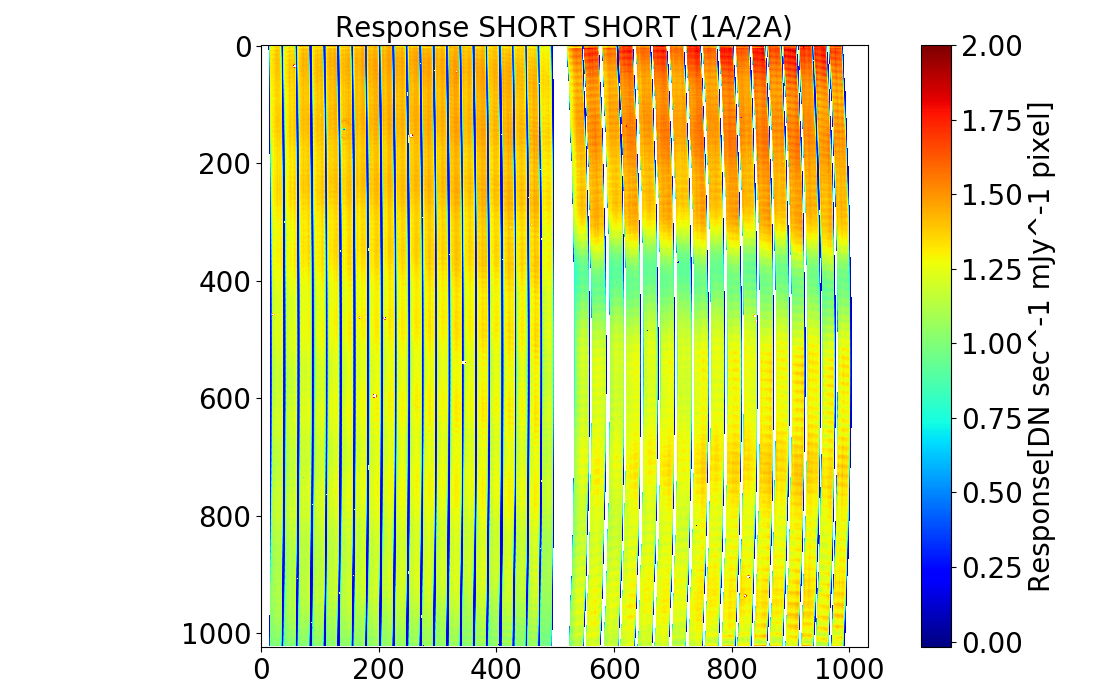

In [20]:
plt.figure(figsize=(11,7))
plt.imshow(resp, vmax=2, interpolation="nearest", cmap='jet')
clb = plt.colorbar()
clb.set_label('Response[DN sec^-1 mJy^-1 pixel]')
plt.title("Response SHORT SHORT (1A/2A)")
plt.tight_layout()

## SHORT MEDIUM = 1B / 2B

In [21]:
hdu0 = makeHeader(detector="MIRIFUSHORT", channel="12", band="MEDIUM")
resp = R_pixMap["800K"]["2B"].copy()
err = dR_pixMap["800K"]["2B"].copy() 
size = sizeMap["2B"].copy()

sel = (validMap["1B"]==1)
resp[sel] = R_pixMap["800K"]["1B"][sel]
err[sel] = dR_pixMap["800K"]["1B"][sel]
size[sel] = sizeMap["1B"][sel]

sel = (( validMap["1B"] + validMap["2B"] )==1)
resp[sel] = resp[sel] # /ff["SHORTMEDIUM"][sel]

dq = np.full( validMap["1B"].shape, 2 )
sel = (validMap["1B"]==1)
dq[sel] = 0
sel = (validMap["2B"]==1)
dq[sel] = 0
dq = dq + BadPixelMap["800K"]["1B"]
dq = dq + BadPixelMap["800K"]["2B"]

hdu1 = fits.ImageHDU(data=resp, header=None, name="SCI")
hdu1.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu2 = fits.ImageHDU(data=err, header=None, name="ERR")
hdu2.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu3 = fits.ImageHDU(data=dq, header=None, name="DQ")
hdu4 = fits.ImageHDU(data=size, header=None, name="PIXSIZ")
hdu4.header["BUNIT"]= "arcsec^2"
hdulist = fits.HDUList([hdu0,hdu1, hdu2, hdu3, dq_def, hdu4])
hdulist.writeto(outDir + "MIRI_FM_MIRIFUSHORT_12MEDIUM_PHOTOM_7B.03.01.fits",overwrite=True )

<IPython.core.display.Javascript object>


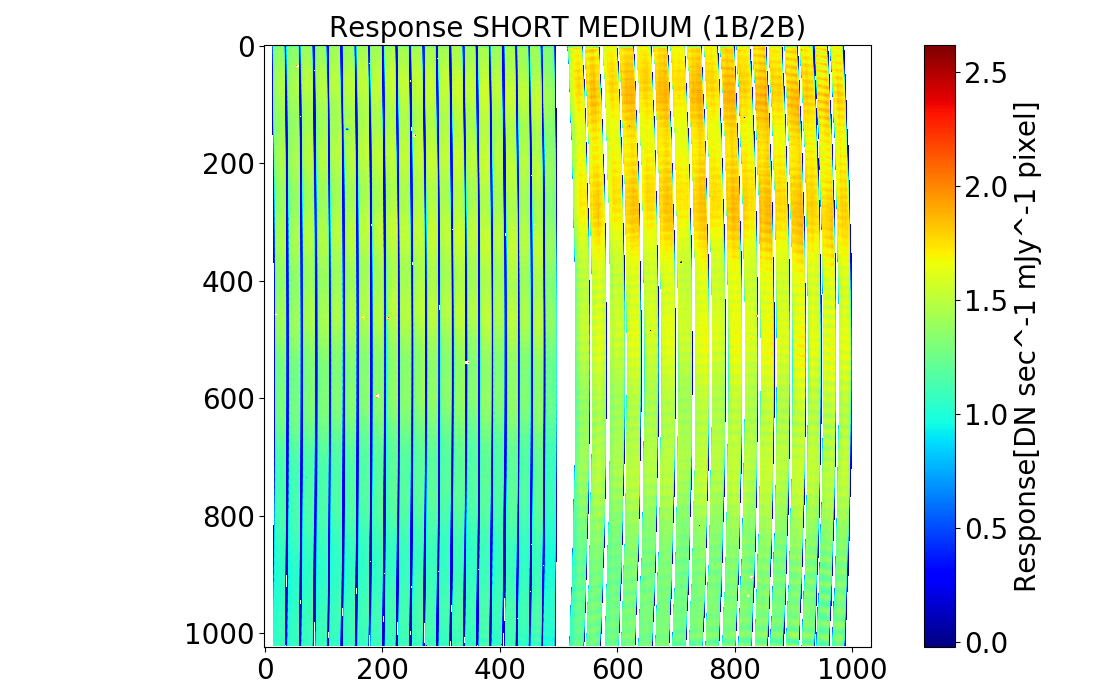

In [22]:
plt.figure(figsize=(11,7))
plt.imshow(resp, interpolation="nearest", cmap='jet')
clb = plt.colorbar()
clb.set_label('Response[DN sec^-1 mJy^-1 pixel]')
plt.title("Response SHORT MEDIUM (1B/2B)")
plt.tight_layout()

## SHORT LONG = 1C / 2C

In [23]:
hdu0 = makeHeader(detector="MIRIFUSHORT", channel="12", band="LONG")
resp = R_pixMap["800K"]["2C"].copy()
err = dR_pixMap["800K"]["2C"].copy() 
size = sizeMap["2C"].copy()

sel = (validMap["1C"]==1)
resp[sel] = R_pixMap["800K"]["1C"][sel]
err[sel] = dR_pixMap["800K"]["1C"][sel]
size[sel] = sizeMap["1C"][sel]

sel = (( validMap["1C"] + validMap["2C"] )==1)
resp[sel] = resp[sel] # /ff["SHORTLONG"][sel]

dq = np.full( validMap["1C"].shape, 2 )
sel = (validMap["1C"]==1)
dq[sel] = 0
sel = (validMap["2C"]==1)
dq[sel] = 0
dq = dq + BadPixelMap["800K"]["1C"]
dq = dq + BadPixelMap["800K"]["2C"]

hdu1 = fits.ImageHDU(data=resp, header=None, name="SCI")
hdu1.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu2 = fits.ImageHDU(data=err, header=None, name="ERR")
hdu2.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu3 = fits.ImageHDU(data=dq, header=None, name="DQ")
hdu4 = fits.ImageHDU(data=size, header=None, name="PIXSIZ")
hdu4.header["BUNIT"]= "arcsec^2"
hdulist = fits.HDUList([hdu0,hdu1, hdu2, hdu3, dq_def, hdu4])
hdulist.writeto(outDir + "MIRI_FM_MIRIFUSHORT_12LONG_PHOTOM_7B.03.01.fits",overwrite=True )

<IPython.core.display.Javascript object>


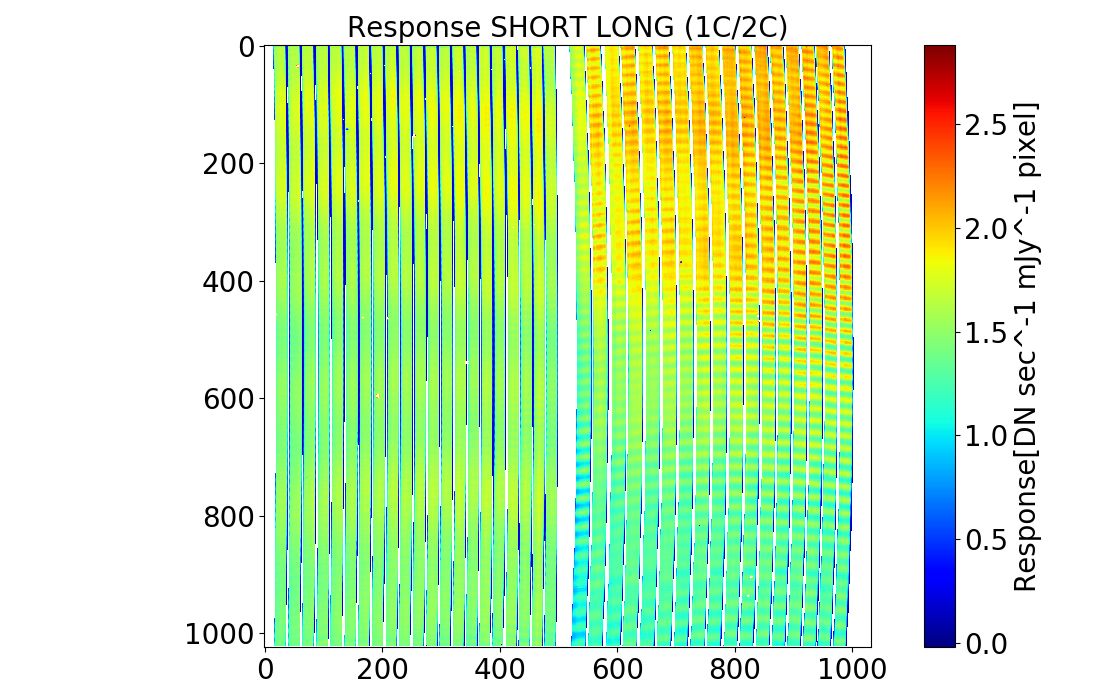

In [24]:
plt.figure(figsize=(11,7))
plt.imshow(resp, interpolation="nearest", cmap='jet')
clb = plt.colorbar()
clb.set_label('Response[DN sec^-1 mJy^-1 pixel]')
plt.title("Response SHORT LONG (1C/2C)")
plt.tight_layout()

## LONG SHORT = 3A / 4A

In [25]:
hdu0 = makeHeader(detector="MIRIFULONG", channel="34", band="SHORT")
resp = R_pixMap["800K"]["4A"].copy()
err = dR_pixMap["800K"]["4A"].copy() 
size = sizeMap["4A"].copy()

sel = (validMap["3A"]==1)
resp[sel] = R_pixMap["800K"]["3A"][sel]
err[sel] = dR_pixMap["800K"]["3A"][sel]
size[sel] = sizeMap["3A"][sel]

sel = (( validMap["3A"] + validMap["4A"] )==1)
resp[sel] = resp[sel] # /ff["LONGSHORT"][sel]

dq = np.full( validMap["3A"].shape, 2 )
sel = (validMap["3A"]==1)
dq[sel] = 0
sel = (validMap["4A"]==1)
dq[sel] = 0
dq = dq + BadPixelMap["800K"]["3A"]
dq = dq + BadPixelMap["800K"]["4A"]

hdu1 = fits.ImageHDU(data=resp, header=None, name="SCI")
hdu1.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu2 = fits.ImageHDU(data=err, header=None, name="ERR")
hdu2.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu3 = fits.ImageHDU(data=dq, header=None, name="DQ")
hdu4 = fits.ImageHDU(data=size, header=None, name="PIXSIZ")
hdu4.header["BUNIT"]= "arcsec^2"
hdulist = fits.HDUList([hdu0,hdu1, hdu2, hdu3, dq_def, hdu4])
hdulist.writeto(outDir + "MIRI_FM_MIRIFULONG_34SHORT_PHOTOM_7B.03.01.fits",overwrite=True )

<IPython.core.display.Javascript object>


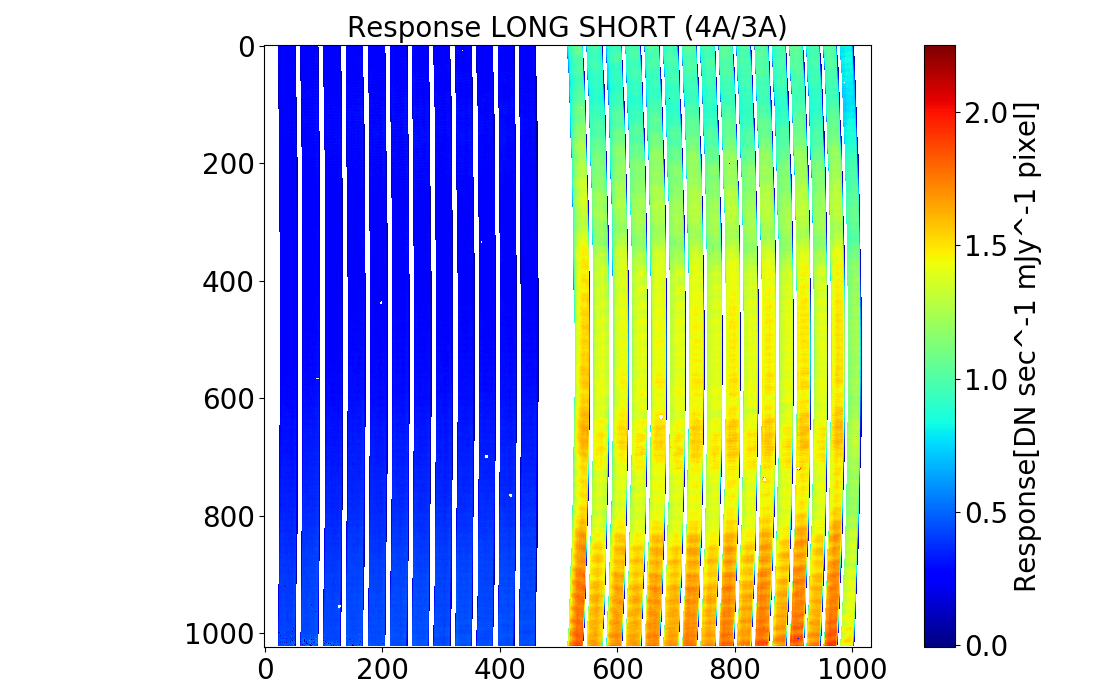

<IPython.core.display.Javascript object>


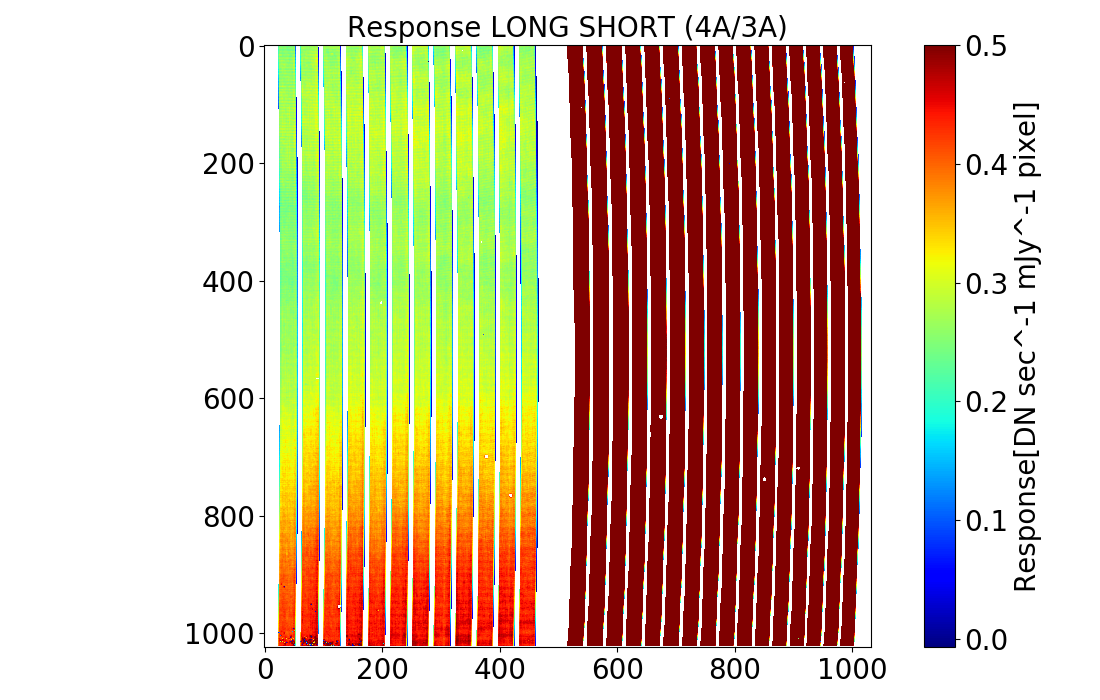

In [27]:
plt.figure(figsize=(11,7))
plt.imshow(resp, interpolation="nearest", cmap='jet')
clb = plt.colorbar()
clb.set_label('Response[DN sec^-1 mJy^-1 pixel]')
plt.title("Response LONG SHORT (4A/3A)")
plt.tight_layout()

plt.figure(figsize=(11,7))
plt.imshow(resp, interpolation="nearest", cmap='jet',vmax=0.5)
clb = plt.colorbar()
clb.set_label('Response[DN sec^-1 mJy^-1 pixel]')
plt.title("Response LONG SHORT (4A/3A)")
plt.tight_layout()

## LONG MEDIUM = 3B / 4B

In [33]:
hdu0 = makeHeader(detector="MIRIFULONG", channel="34", band="MEDIUM")
resp = R_pixMap["800K"]["4B"].copy()
err = dR_pixMap["800K"]["4B"].copy() 
size = sizeMap["4B"].copy()

sel = (validMap["3B"]==1)
resp[sel] = R_pixMap["800K"]["3B"][sel]
err[sel] = dR_pixMap["800K"]["3B"][sel]
size[sel] = sizeMap["3B"][sel]

sel = (( validMap["3B"] + validMap["4B"] )==1)
resp[sel] = resp[sel] # /ff["LONGMEDIUM"][sel]

dq = np.full( validMap["3B"].shape, 2 )
sel = (validMap["3B"]==1)
dq[sel] = 0
sel = (validMap["4B"]==1)
dq[sel] = 0
dq = dq + BadPixelMap["800K"]["3B"]
dq = dq + BadPixelMap["800K"]["4B"]

hdu1 = fits.ImageHDU(data=resp, header=None, name="SCI")
hdu1.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu2 = fits.ImageHDU(data=err, header=None, name="ERR")
hdu2.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu3 = fits.ImageHDU(data=dq, header=None, name="DQ")
hdu4 = fits.ImageHDU(data=size, header=None, name="PIXSIZ")
hdu4.header["BUNIT"]= "arcsec^2"
hdulist = fits.HDUList([hdu0,hdu1, hdu2, hdu3, dq_def, hdu4])
hdulist.writeto(outDir + "MIRI_FM_MIRIFULONG_34MEDIUM_PHOTOM_7B.03.01.fits",overwrite=True )

<IPython.core.display.Javascript object>


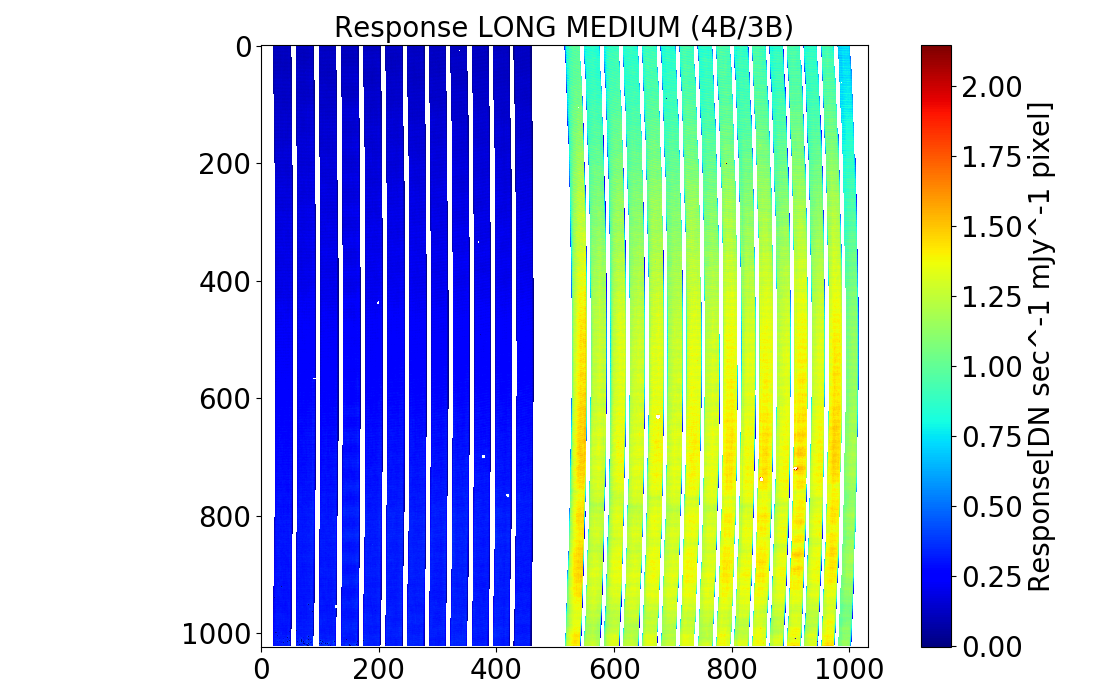

<IPython.core.display.Javascript object>


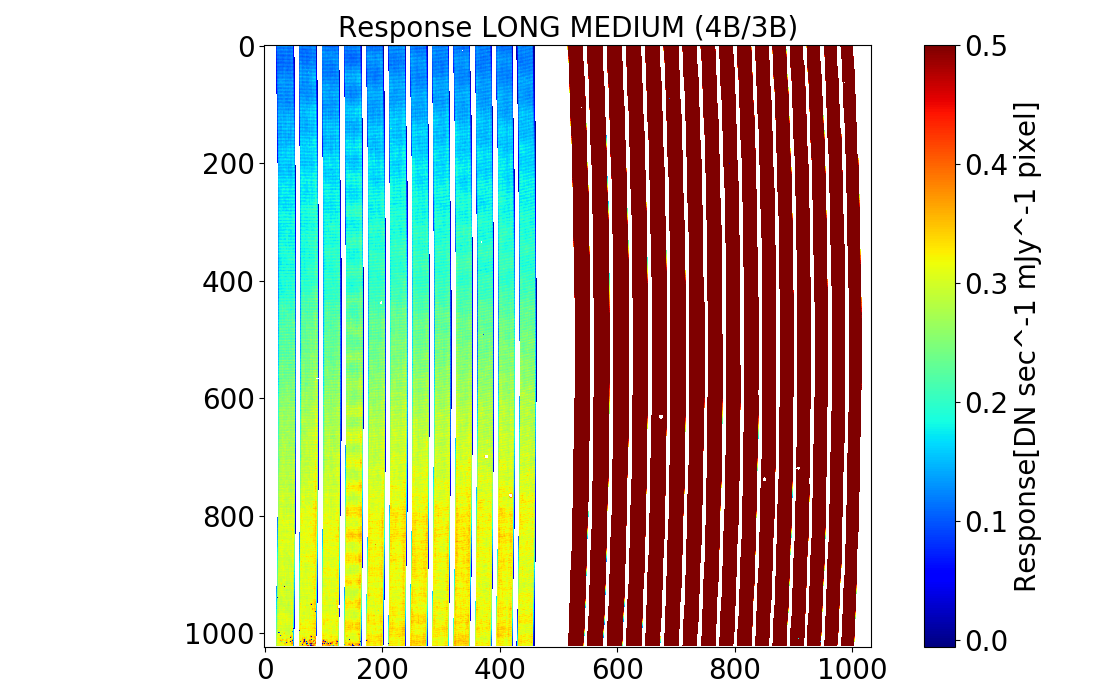

In [34]:
plt.figure(figsize=(11,7))
plt.imshow(resp, interpolation="nearest", cmap='jet')
clb = plt.colorbar()
clb.set_label('Response[DN sec^-1 mJy^-1 pixel]')
plt.title("Response LONG MEDIUM (4B/3B)")
plt.tight_layout()

plt.figure(figsize=(11,7))
plt.imshow(resp, vmax = 0.5,interpolation="nearest", cmap='jet')
clb = plt.colorbar()
clb.set_label('Response[DN sec^-1 mJy^-1 pixel]')
plt.title("Response LONG MEDIUM (4B/3B)")
plt.tight_layout()

## LONG LONG = 3C / 4C

In [35]:
hdu0 = makeHeader(detector="MIRIFULONG", channel="34", band="LONG")
resp = R_pixMap["800K"]["4C"].copy()
err = dR_pixMap["800K"]["4C"].copy() 
size = sizeMap["4C"].copy()

sel = (validMap["3C"]==1)
resp[sel] = R_pixMap["800K"]["3C"][sel]
err[sel] = dR_pixMap["800K"]["3C"][sel]
size[sel] = sizeMap["3C"][sel]

sel = (( validMap["3C"] + validMap["4C"] )==1)
resp[sel] = resp[sel] # /ff["LONGLONG"][sel]

dq = np.full( validMap["3C"].shape, 2 )
sel = (validMap["3C"]==1)
dq[sel] = 0
sel = (validMap["4C"]==1)
dq[sel] = 0
dq = dq + BadPixelMap["800K"]["3C"]
dq = dq + BadPixelMap["800K"]["4C"]

hdu1 = fits.ImageHDU(data=resp, header=None, name="SCI")
hdu1.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu2 = fits.ImageHDU(data=err, header=None, name="ERR")
hdu2.header["BUNIT"]= "DN sec^-1 mJy^-1 pixel"
hdu3 = fits.ImageHDU(data=dq, header=None, name="DQ")
hdu4 = fits.ImageHDU(data=size, header=None, name="PIXSIZ")
hdu4.header["BUNIT"]= "arcsec^2"
hdulist = fits.HDUList([hdu0,hdu1, hdu2, hdu3, dq_def, hdu4])
hdulist.writeto(outDir + "MIRI_FM_MIRIFULONG_34LONG_PHOTOM_7B.03.01.fits",overwrite=True )

<IPython.core.display.Javascript object>


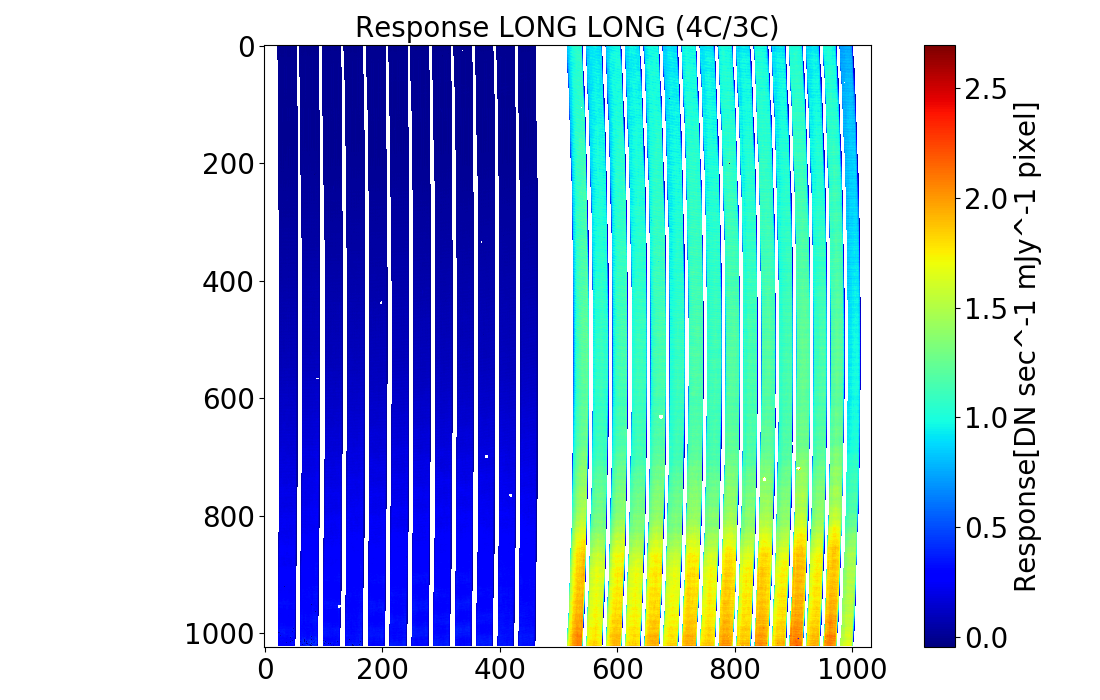

<IPython.core.display.Javascript object>


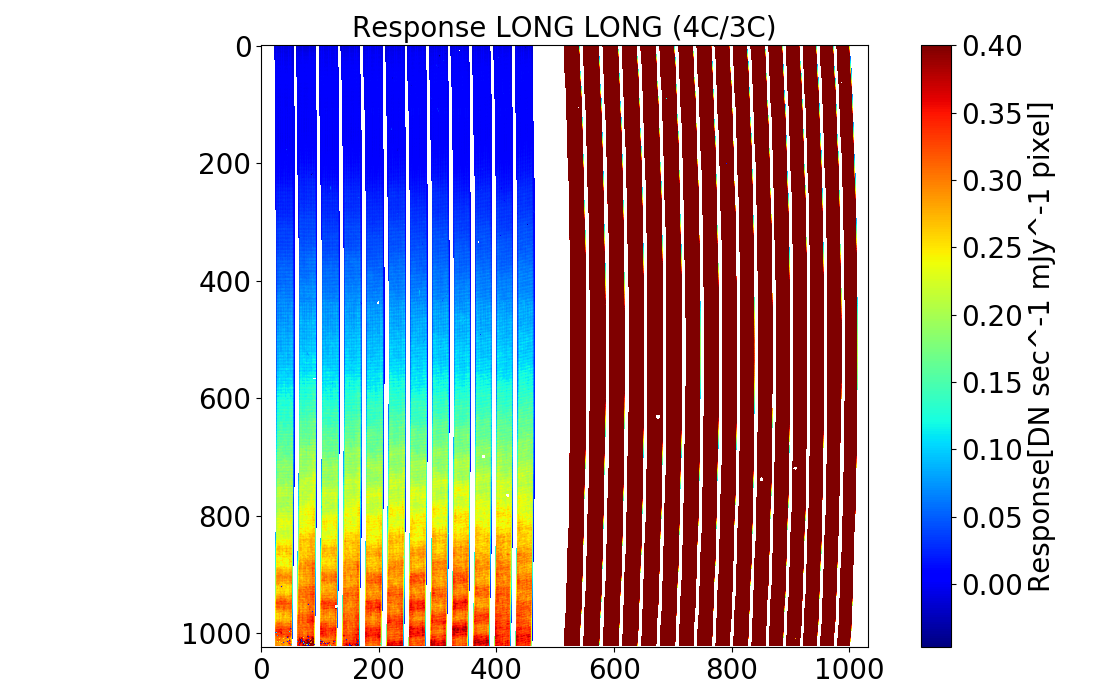

In [38]:
plt.figure(figsize=(11,7))
plt.imshow(resp, interpolation="nearest", cmap='jet')
clb = plt.colorbar()
clb.set_label('Response[DN sec^-1 mJy^-1 pixel]')
plt.title("Response LONG LONG (4C/3C)")
plt.tight_layout()

plt.figure(figsize=(11,7))
plt.imshow(resp, interpolation="nearest", cmap='jet',vmax=0.4)
clb = plt.colorbar()
clb.set_label('Response[DN sec^-1 mJy^-1 pixel]')
plt.title("Response LONG LONG (4C/3C)")
plt.tight_layout()